# MLLoopOptSelector — Research Dashboard

Interactive report for pipeline outputs in **artifacts/**:

- Training summary (`report.json` / `.txt`)
- Cross-validation (`cv.json`)
- Leave-One-Kernel-Out (`loko.json`)
- Feature importances (`feature_importance.csv`)
- Visuals (`tile_runtime_3d.png`, `explain.png`)

> Tip: run `make workflow` first, then re-run this notebook.

In [1]:
# Imports & setup
import json, os, math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display, Image

ART = Path("../artifacts")
ART.mkdir(exist_ok=True)

def load_json(p):
    p = ART / p if not str(p).startswith("/") else Path(p)
    return json.loads(p.read_text()) if p.exists() else None

def exists(rel):
    return (ART / rel).exists()

print("Artifacts directory:", ART.resolve())

Artifacts directory: /Users/ayesharahman1/Desktop/MLLoopOptSelector/artifacts


In [2]:
report = load_json("report.json")
cv     = load_json("cv.json")
loko   = load_json("loko.json")

fi = None
fi_csv = ART / "feature_importance.csv"
if fi_csv.exists():
    fi = pd.read_csv(fi_csv, header=None, names=["feature","importance"])\
           .sort_values("importance", ascending=False)

df = None
dataset_csv = ART / "dataset.csv"
if dataset_csv.exists():
    df = pd.read_csv(dataset_csv)

print("Loaded:")
print(" - report.json:", report is not None)
print(" - cv.json:", cv is not None)
print(" - loko.json:", loko is not None)
print(" - feature_importance.csv:", fi is not None)
print(" - dataset.csv:", df is not None)


Loaded:
 - report.json: True
 - cv.json: True
 - loko.json: True
 - feature_importance.csv: True
 - dataset.csv: True


In [3]:
if report:
    rows = [
        ("Model picked", report.get("model_picked")),
        ("Select-by", report.get("select_by")),
        ("Train Acc", f"{report.get('train_acc', float('nan')):.3f}"),
        ("Test Acc",  f"{report.get('test_acc', float('nan')):.3f}"),
        ("Train F1 (macro)", f"{report.get('train_f1_macro', float('nan')):.3f}"),
        ("Test F1 (macro)",  f"{report.get('test_f1_macro', float('nan')):.3f}"),
        ("Val median regret", f"{report.get('val_med_regret', float('nan')):.3f}"),
        ("CV Acc (mean)", f"{report.get('cv_acc_mean', float('nan')):.3f}"),
        ("CV F1 (macro mean)", f"{report.get('cv_f1_macro_mean', float('nan')):.3f}"),
        ("n_train", report.get("n_train")),
        ("n_test", report.get("n_test")),
        ("Cost-weighting", report.get("cost_weighting")),
    ]
    display(pd.DataFrame(rows, columns=["Metric","Value"]))
else:
    print("report.json not found — run `make workflow`.")


,Metric,Value
0,Model picked,ExtraTrees (sel_by=f1)
1,Select-by,f1
2,Train Acc,0.946
3,Test Acc,0.843
4,Train F1 (macro),0.919
5,Test F1 (macro),0.396
6,Val median regret,1.000
7,CV Acc (mean),0.735
8,CV F1 (macro mean),0.443
9,n_train,698


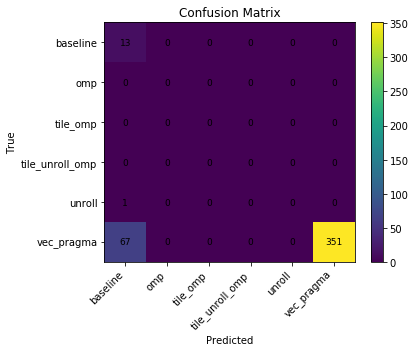

In [4]:
if report and report.get("confusion_matrix") is not None:
    labels = report.get("classes", [])
    cm = np.array(report["confusion_matrix"])
    if cm.size > 0:
        fig = plt.figure(figsize=(6,5))
        ax = plt.gca()
        im = ax.imshow(cm, aspect='auto')
        fig.colorbar(im, ax=ax)
        ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
        ax.set_xlabel('Predicted'); ax.set_ylabel('True')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, int(cm[i, j]), ha='center', va='center', fontsize=9)
        ax.set_title('Confusion Matrix')
        plt.tight_layout(); plt.show()
    else:
        print("No confusion matrix data.")
else:
    print("No confusion matrix in report.json.")


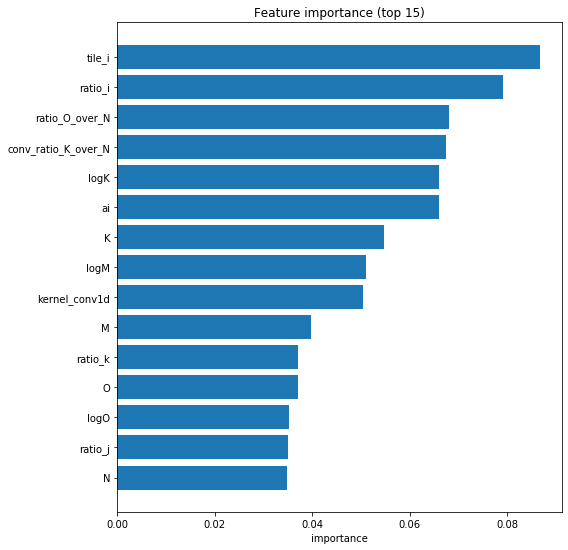

Explainability snapshot (SHAP or permutation):


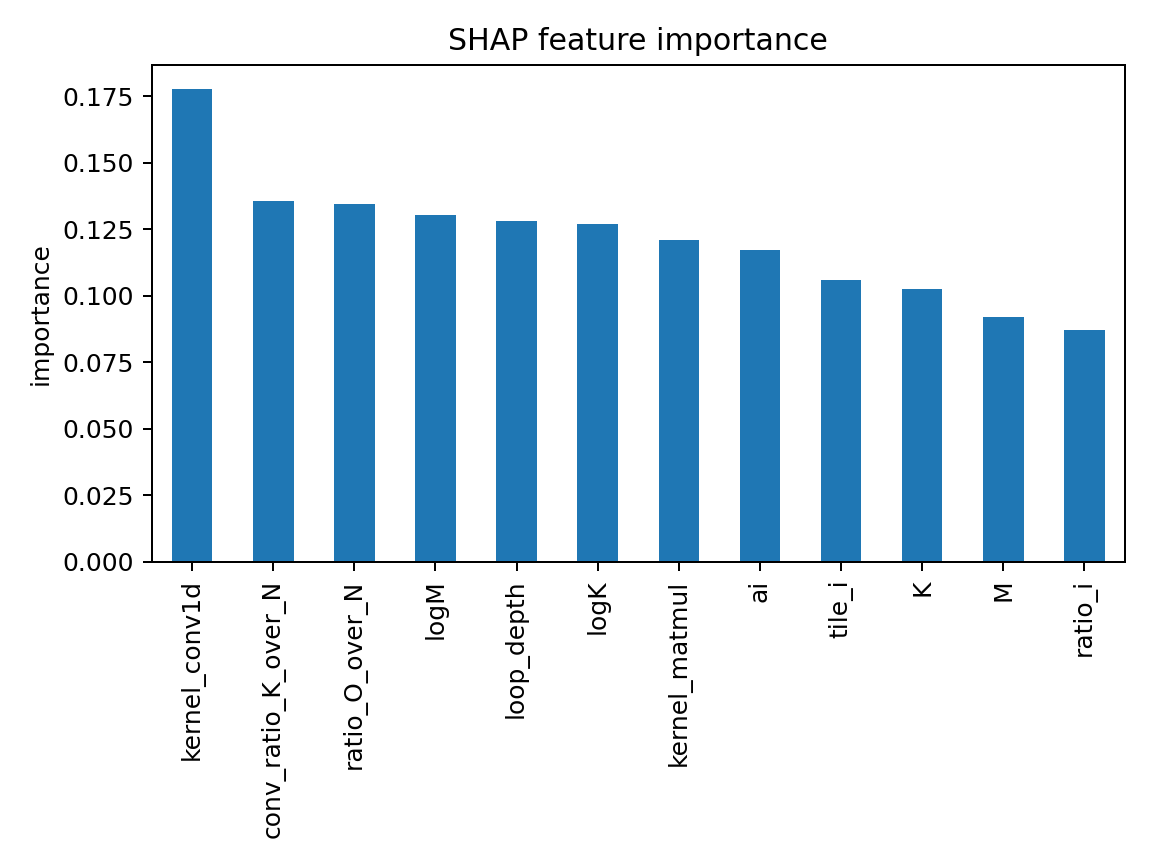

In [5]:
if fi is not None and len(fi):
    topk = 15
    fig = plt.figure(figsize=(8, 4 + 0.25*topk))
    ax = plt.gca()
    use = fi.head(topk).sort_values("importance")
    ax.barh(use["feature"], use["importance"])
    ax.set_title("Feature importance (top 15)")
    ax.set_xlabel("importance")
    plt.tight_layout(); plt.show()
else:
    print("feature_importance.csv not found. After training with a tree-based model, this will appear.")

exp_png = ART / "explain.png"
if exp_png.exists():
    print("Explainability snapshot (SHAP or permutation):")
    display(Image(filename=str(exp_png)))
else:
    print("explain.png not found — run `make explain` or `make workflow`.")


,kernel,acc,f1_macro,regret_median,speedup_median,coverage,n
0,matmul,0.989362,0.66457,1.0,6.595286,1.0,94
1,conv1d,0.897606,0.71233,1.0,2.57098,1.0,752
2,stencil2d,1.0,1.0,1.0,1.019419,1.0,176


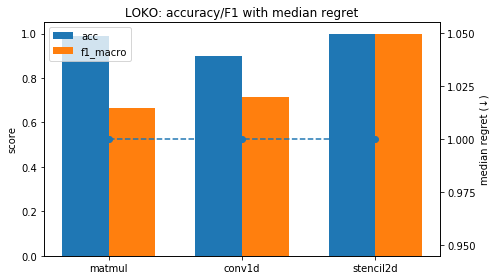

In [6]:
from matplotlib.ticker import MaxNLocator

if loko:
    lokodf = (pd.DataFrame(loko).T
              .reset_index()
              .rename(columns={"index": "kernel"}))

    display(lokodf[["kernel","acc","f1_macro","regret_median","speedup_median","coverage","n"]])

    x = np.arange(len(lokodf))
    w = 0.35

    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.bar(x - w/2, lokodf["acc"].to_numpy(float), width=w, label="acc")
    ax1.bar(x + w/2, lokodf["f1_macro"].to_numpy(float), width=w, label="f1_macro")
    ax1.set_xticks(x)
    ax1.set_xticklabels(lokodf["kernel"])
    ax1.set_ylim(0, 1.05)
    ax1.set_ylabel("score")
    ax1.legend(loc="upper left")

    # ---> The key fix: convert to 1-D NumPy array
    reg_med = pd.to_numeric(lokodf["regret_median"], errors="coerce").to_numpy()

    ax2 = ax1.twinx()
    ax2.plot(x, reg_med, marker="o", linestyle="--")
    ax2.set_ylabel("median regret (↓)")
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))

    ax1.set_title("LOKO: accuracy/F1 with median regret")
    plt.tight_layout()
    plt.show()
else:
    print("loko.json not found — run `make loko` or `make workflow`.")

In [7]:
if cv:
    display(pd.DataFrame({k:[v] for k,v in cv.items()}))
else:
    print("cv.json not found — run `make cv` or `make workflow`.")


,k,acc_mean,f1_macro_mean
0,5,0.742097,0.458803


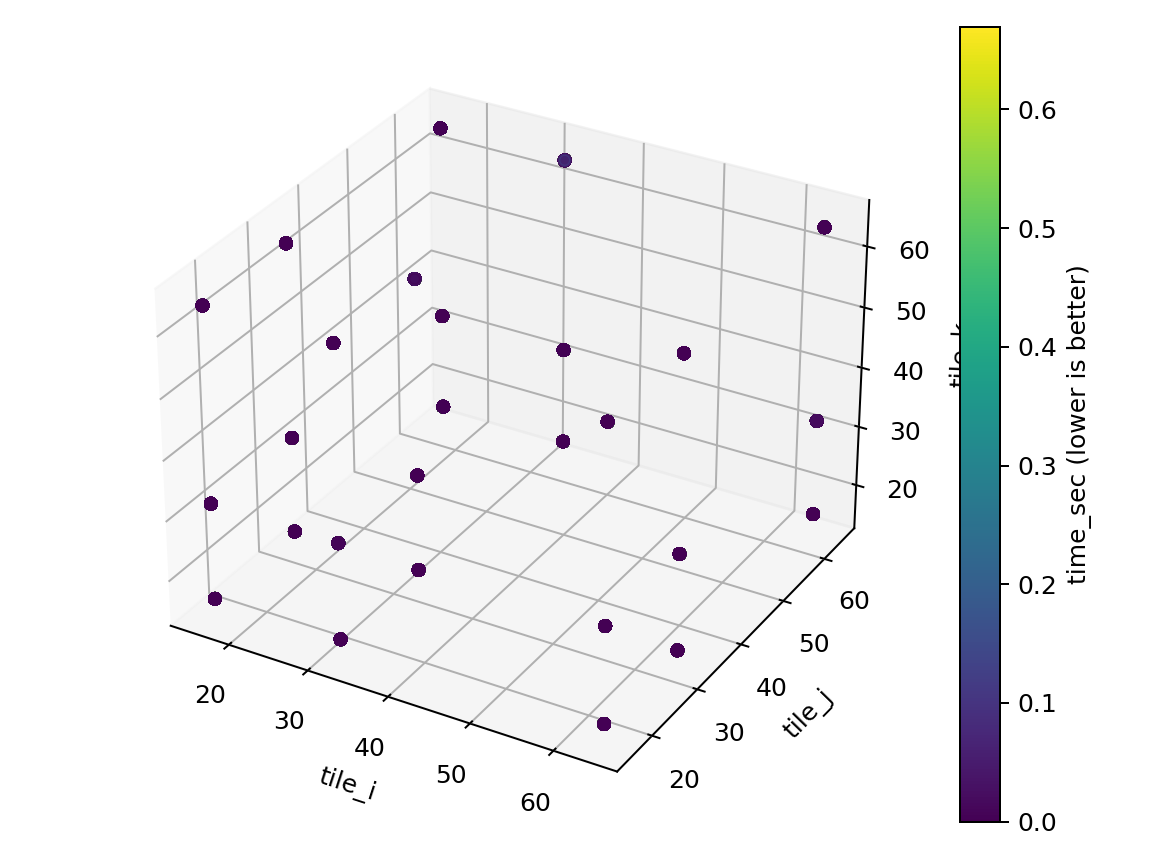

,kernel_matmul,kernel_conv1d,kernel_stencil2d,loop_depth,ai,N,M,K,logN,logM,...,mis_j,mis_k,conv_ratio_K_over_N,choice,time_sec,checksum,compile_macros,kernel,group_id,best_choice
0,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002684,0.0,-DTILE_I=16 -DTILE_J=16 -DTILE_K=64,matmul,758,tile_unroll_omp
1,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002738,0.0,-DTILE_I=16 -DTILE_J=16 -DTILE_K=32,matmul,757,tile_unroll_omp
2,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002678,0.0,-DTILE_I=16 -DTILE_J=16 -DTILE_K=16,matmul,756,tile_unroll_omp
3,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002635,0.0,-DTILE_I=16 -DTILE_J=32 -DTILE_K=16,matmul,759,tile_unroll_omp
4,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002664,0.0,-DTILE_I=16 -DTILE_J=32 -DTILE_K=32,matmul,760,omp
5,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002636,0.0,-DTILE_I=16 -DTILE_J=32 -DTILE_K=64,matmul,761,omp
6,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002660,0.0,-DTILE_I=16 -DTILE_J=64 -DTILE_K=16,matmul,762,omp
7,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002781,0.0,-DTILE_I=16 -DTILE_J=64 -DTILE_K=32,matmul,763,omp
8,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002978,0.0,-DTILE_I=16 -DTILE_J=64 -DTILE_K=64,matmul,764,omp
9,1,0,0,3,21.333333,128,128,128,4.85203,4.85203,...,0.0,0.0,0.0,baseline,0.002860,0.0,-DTILE_I=32 -DTILE_J=16 -DTILE_K=16,matmul,765,omp


Rows: 9,072


In [8]:
tile_png = ART / "tile_runtime_3d.png"
if tile_png.exists():
    display(Image(filename=str(tile_png)))
else:
    print("tile_runtime_3d.png not found — run `make vis3d` or `make workflow`.")

if df is not None:
    display(df.head(10))
    print(f"Rows: {len(df):,}")
else:
    print("dataset.csv not found.")


In [9]:
report = load_json("report.json")
cv     = load_json("cv.json")
loko   = load_json("loko.json")

fi = None
fi_csv = ART / "feature_importance.csv"
if fi_csv.exists():
    fi = pd.read_csv(fi_csv, header=None, names=["feature","importance"])\
           .sort_values("importance", ascending=False)

df = None
dataset_csv = ART / "dataset.csv"
if dataset_csv.exists():
    df = pd.read_csv(dataset_csv)

print("Loaded:")
print(" - report.json:", report is not None)
print(" - cv.json:", cv is not None)
print(" - loko.json:", loko is not None)
print(" - feature_importance.csv:", fi is not None)
print(" - dataset.csv:", df is not None)


Loaded:
 - report.json: True
 - cv.json: True
 - loko.json: True
 - feature_importance.csv: True
 - dataset.csv: True


In [10]:
if df is not None:
    cfg = df.drop_duplicates(subset=["group_id"]) if "group_id" in df.columns else df
    if "best_choice" in cfg.columns:
        print("Label distribution (best_choice):")
        display(cfg["best_choice"].value_counts().to_frame("count"))
    if {"kernel","N"}.issubset(cfg.columns):
        grp = cfg.groupby(["kernel","N"]).size().reset_index(name="n")
        print("Unique (kernel,N) groups:", len(grp))
else:
    print("dataset.csv not found.")


Label distribution (best_choice):


,count
best_choice,
vec_pragma,648
baseline,206
omp,134
tile_unroll_omp,100
tile_omp,23
unroll,19
tile,4


Unique (kernel,N) groups: 21


# GNN

In [11]:
# Setup & Load (no retrainining)
from pathlib import Path
import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ART = Path("../artifacts")
if not ART.exists():
    ART = Path("artifacts")
assert ART.exists(), f"Artifacts folder not found at {ART.resolve()}"

def jload(name): 
    p = ART / name
    return json.loads(p.read_text()) if p.exists() else None

def cload(name):
    p = ART / name
    return pd.read_csv(p) if p.exists() else None

report          = jload("report.json")
loko            = jload("loko.json")
cv              = jload("cv.json")
gnn_report      = jload("gnn_report.json")
gnn_regret_sum  = jload("gnn_regret_summary.json")
gnn_regret_det  = cload("gnn_regret_details.csv")
feat_importance = cload("feature_importance.csv")
dataset         = cload("dataset.csv")

print("Loaded:", {
    "report": bool(report), "loko": bool(loko), "cv": bool(cv),
    "gnn_report": bool(gnn_report), "gnn_regret_summary": bool(gnn_regret_sum),
    "gnn_regret_details": None if gnn_regret_det is None else gnn_regret_det.shape,
    "feature_importance": None if feat_importance is None else feat_importance.shape,
    "dataset_rows": None if dataset is None else len(dataset),
})

# Compact metric row for later
metrics = {}
if report:
    metrics.update({
        "tab_acc": report.get("test_acc"),
        "tab_f1": report.get("test_f1_macro"),
        "tab_model": report.get("model_picked"),
        "cv_acc": (cv or {}).get("acc_mean"),
        "cv_f1": (cv or {}).get("f1_macro_mean"),
    })
if gnn_report:
    metrics.update({"gnn_acc": gnn_report.get("acc"), "gnn_f1": gnn_report.get("f1_macro")})
if gnn_regret_sum:
    metrics.update({
        "gnn_regret_median": gnn_regret_sum.get("regret_median"),
        "gnn_speedup_median": gnn_regret_sum.get("speedup_vs_baseline_median"),
        "gnn_regret_mean": gnn_regret_sum.get("regret_mean"),
        "gnn_regret_90p": gnn_regret_sum.get("regret_90p"),
    })

pd.DataFrame([metrics])

Loaded: {'report': True, 'loko': True, 'cv': True, 'gnn_report': True, 'gnn_regret_summary': True, 'gnn_regret_details': (1134, 10), 'feature_importance': (24, 2), 'dataset_rows': 9072}


,tab_acc,tab_f1,tab_model,cv_acc,cv_f1,gnn_acc,gnn_f1,gnn_regret_median,gnn_speedup_median,gnn_regret_mean,gnn_regret_90p
0,0.842593,0.39649,ExtraTrees (sel_by=f1),0.742097,0.458803,0.623239,0.389298,1.0,2.998002,22.739827,1.4995


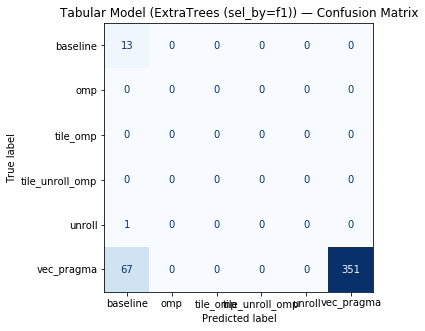

,precision,recall,f1-score,support
baseline,0.160,1.000,0.277,13.000
unroll,0.000,0.000,0.000,1.000
vec_pragma,1.000,0.840,0.913,418.000
accuracy,0.843,0.843,0.843,0.843
macro avg,0.387,0.613,0.396,432.000
weighted avg,0.972,0.843,0.892,432.000


In [12]:
# Confusion Matrix & Label Report (tabular model)
if not report:
    print("report.json not found — skip confusion matrix.")
else:
    labels = sorted(report["classes"])
    cm = np.asarray(report["confusion_matrix"], dtype=int)

    fig, ax = plt.subplots(figsize=(5.5, 5))
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(
        include_values=True, cmap="Blues", ax=ax, colorbar=False
    )
    ax.set_title(f"Tabular Model ({report['model_picked']}) — Confusion Matrix")
    plt.tight_layout(); plt.show()

    cr = pd.DataFrame(report["classification_report"]).T
    display(cr.round(3))

,kernel,model_family,acc,f1_macro,regret_median,speedup_median,coverage,n
0,matmul,RandomForest,0.989362,0.66457,1.0,6.595286,1.0,94
1,conv1d,RandomForest,0.897606,0.71233,1.0,2.57098,1.0,752
2,stencil2d,RandomForest,1.0,1.0,1.0,1.019419,1.0,176


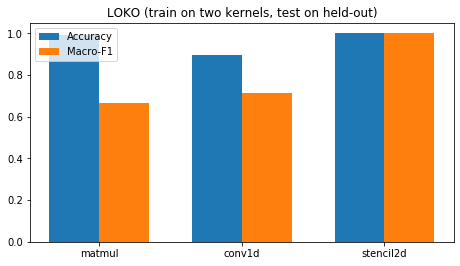

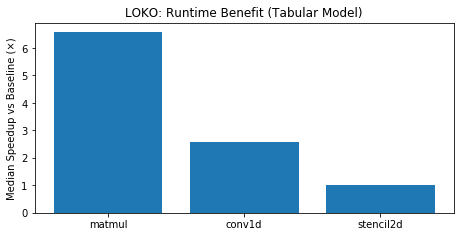

In [13]:
# LOKO per-kernel metrics
if not loko:
    print("loko.json not found — skipping LOKO plots.")
else:
    loko_df = pd.DataFrame(loko).T.reset_index().rename(columns={"index":"kernel"})
    display(loko_df[["kernel","model_family","acc","f1_macro","regret_median","speedup_median","coverage","n"]])

    # Acc & F1 bars
    fig, ax = plt.subplots(figsize=(6.5, 3.8))
    x = np.arange(len(loko_df))
    w = 0.35
    ax.bar(x - w/2, loko_df["acc"], width=w, label="Accuracy")
    ax.bar(x + w/2, loko_df["f1_macro"], width=w, label="Macro-F1")
    ax.set_xticks(x)
    ax.set_xticklabels(loko_df["kernel"])
    ax.set_ylim(0, 1.05)
    ax.set_title("LOKO (train on two kernels, test on held-out)")
    ax.legend()
    plt.tight_layout(); plt.show()

    # Median speedup vs baseline
    fig, ax = plt.subplots(figsize=(6.5, 3.4))
    ax.bar(loko_df["kernel"], loko_df["speedup_median"])
    ax.set_ylabel("Median Speedup vs Baseline (×)")
    ax.set_title("LOKO: Runtime Benefit (Tabular Model)")
    plt.tight_layout(); plt.show()

In [14]:
x = np.arange(len(loko_df))
w = 0.35
ax.bar(x - w/2, loko_df["acc"], width=w, label="Accuracy")
ax.bar(x + w/2, loko_df["f1_macro"], width=w, label="Macro-F1")
ax.set_xticks(x)
ax.set_xticklabels(loko_df["kernel"])
ax.set_ylim(0, 1.05)
ax.set_title("LOKO (Train on two kernels, test on held-out)")
ax.legend()
plt.tight_layout(); plt.show()

<Figure size 432x288 with 0 Axes>

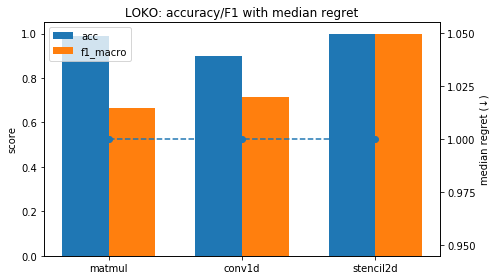

In [15]:
from matplotlib.ticker import MaxNLocator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

x = np.arange(len(lokodf), dtype=float)
w = 0.35

fig, ax1 = plt.subplots(figsize=(7, 4))
ax1.bar(x - w/2, lokodf["acc"].to_numpy(float), width=w, label="acc")
ax1.bar(x + w/2, lokodf["f1_macro"].to_numpy(float), width=w, label="f1_macro")
ax1.set_xticks(x)
ax1.set_xticklabels(lokodf["kernel"].tolist())
ax1.set_ylim(0, 1.05)
ax1.set_ylabel("score")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(x, lokodf["regret_median"].to_numpy(float), marker="o", linestyle="--")
ax2.set_ylabel("median regret (↓)")
ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax1.set_title("LOKO: accuracy/F1 with median regret")
plt.tight_layout()
plt.show()

In [16]:
# Auto-written summary
def fmt(x, nd=3): 
    return "—" if x is None else (f"{x:.{nd}f}" if isinstance(x, (int,float)) else str(x))

lines = []
lines.append("## Results & Research Summary")
if report:
    lines += [
        f"- **Final tabular model:** `{report['model_picked']}`",
        f"- **Test accuracy / macro-F1:** {fmt(metrics.get('tab_acc'))} / {fmt(metrics.get('tab_f1'))}",
    ]
if cv:
    lines.append(f"- **Cross-validated (k={cv.get('k','—')}):** acc={fmt(metrics.get('cv_acc'))}, macro-F1={fmt(metrics.get('cv_f1'))}")
if loko:
    ldf = pd.DataFrame(loko).T.reset_index().rename(columns={"index":"kernel"})
    for _, r in ldf.iterrows():
        lines.append(f"- **LOKO {r.kernel}** — acc={fmt(r.acc)}, F1={fmt(r.f1_macro)}, median regret={fmt(r.regret_median)}, median speedup×={fmt(r.speedup_median)}")
if gnn_report or gnn_regret_sum:
    lines.append(f"- **GNN (held-out set)** — acc={fmt(metrics.get('gnn_acc'))}, macro-F1={fmt(metrics.get('gnn_f1'))}")
    lines.append(f"- **GNN runtime** — median regret={fmt(metrics.get('gnn_regret_median'))}, median speedup×={fmt(metrics.get('gnn_speedup_median'))}, mean regret={fmt(metrics.get('gnn_regret_mean'))}, 90p regret={fmt(metrics.get('gnn_regret_90p'))}")
lines.append("- **Design choices:** grouped stratified CV; regret-aware model selection; small-output OMP guard for conv1d; per-kernel hybrid verify (top-K) in LOKO; SHAP + 3D tile/runtime visuals; graph path (graphify→GNN→regret).")

print("\n".join(lines))

## Results & Research Summary
- **Final tabular model:** `ExtraTrees (sel_by=f1)`
- **Test accuracy / macro-F1:** 0.843 / 0.396
- **Cross-validated (k=5):** acc=0.742, macro-F1=0.459
- **LOKO matmul** — acc=0.989, F1=0.665, median regret=1.000, median speedup×=6.595
- **LOKO conv1d** — acc=0.898, F1=0.712, median regret=1.000, median speedup×=2.571
- **LOKO stencil2d** — acc=1.000, F1=1.000, median regret=1.000, median speedup×=1.019
- **GNN (held-out set)** — acc=0.623, macro-F1=0.389
- **GNN runtime** — median regret=1.000, median speedup×=2.998, mean regret=22.740, 90p regret=1.500
- **Design choices:** grouped stratified CV; regret-aware model selection; small-output OMP guard for conv1d; per-kernel hybrid verify (top-K) in LOKO; SHAP + 3D tile/runtime visuals; graph path (graphify→GNN→regret).
